# Imports

In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sqlalchemy import create_engine

import credentials

# Data loading

In [62]:
db_con = create_engine(credentials.DB_URL)

train_df = pd.read_sql('SELECT * FROM cleaned.train_set', db_con)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2620 entries, 0 to 2619
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ph                              2620 non-null   float64
 1   Hardness                        2620 non-null   float64
 2   Chloramines                     2620 non-null   float64
 3   Sulfate                         2620 non-null   float64
 4   Conductivity                    2620 non-null   float64
 5   Organic_carbon                  2620 non-null   float64
 6   Trihalomethanes                 2620 non-null   float64
 7   Turbidity                       2620 non-null   float64
 8   Solids_sqrt                     2620 non-null   float64
 9   ph Hardness                     2620 non-null   float64
 10  ph Chloramines                  2620 non-null   float64
 11  ph Sulfate                      2620 non-null   float64
 12  ph Conductivity                 26

# Analytical question

What feature interactions between metrics measured in the dataset are useful for predicting water potibility?

# New Features

I didn't know that this would be the assignment when I did week 3's, so I already created new features for each metrics interaction with all other metrics. I am currently lacking domain knowledge as to how these metrics impact the target variable (potibility). That's why I created all the interactions between all metrics. My intention is to take these and whittle them down using feature importance from random trees and another method that I have yet to research. The new features that were created are more numerous that what is requested in the assignment, but with my lacking in domain knowledge, I thought it would be best to create all possible interactions. Some additional reasoning for this approach is that there are only 8 predictive features in the original dataset, so creating and testing all possible interactions isn't too computationally expensive given the size of the dataset. 

## Small data change

I want to flip the numbers for potability so that 0 is potable and 1 is not. This is so that when recall is calculated, it is calculated for not potable water. This is because I think it is more important to have a high recall for not potable water than it is to have a high recall for potable water.

In [63]:
train_df.Potibility.value_counts()

Potibility
0.0    1587
1.0    1033
Name: count, dtype: int64

In [64]:
# Flipping the target
train_df['not_potible'] = 1 - train_df['Potibility']
train_df.not_potible.value_counts()

not_potible
1.0    1587
0.0    1033
Name: count, dtype: int64

In [65]:
train_df.drop('Potibility', axis=1, inplace=True)
train_df

,ph,Hardness,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Solids_sqrt,ph Hardness,...,Conductivity Trihalomethanes,Conductivity Turbidity,Conductivity Solids_sqrt,Organic_carbon Trihalomethanes,Organic_carbon Turbidity,Organic_carbon Solids_sqrt,Trihalomethanes Turbidity,Trihalomethanes Solids_sqrt,Turbidity Solids_sqrt,not_potible
0,8.846282,188.415001,6.057868,317.150545,419.395569,17.115447,60.251578,2.925038,133.172631,1666.772221,...,25269.244939,1226.747791,55852.011326,1031.232680,50.063325,2279.309075,176.238129,8023.861190,389.534947,1.0
1,5.166226,135.712166,8.637098,334.494997,362.217258,11.185554,76.067064,4.608319,109.818075,701.119717,...,27552.803253,1669.212815,39778.001880,850.852241,51.546605,1228.375992,350.541325,8353.538489,506.076763,1.0
2,8.195765,214.517610,6.295405,327.193898,403.189913,15.067042,72.756812,3.218709,101.929105,1758.136000,...,29334.812882,1297.751092,41096.787156,1096.229924,48.496426,1535.770077,234.183023,7416.036809,328.080152,0.0
3,6.809645,179.719521,8.681983,334.494997,360.932804,13.633350,72.717920,3.183804,187.085929,1223.826048,...,26246.282671,1149.139150,67525.448873,991.388833,43.405908,2550.607900,231.519573,13604.499568,595.644849,0.0
4,7.065416,189.001086,10.088771,312.954695,419.534133,14.801684,62.535071,5.149542,144.168540,1335.371317,...,26235.596745,2160.408824,60483.623336,925.624362,76.221900,2133.937178,322.027002,9015.589854,742.402015,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2615,7.965337,151.541889,7.106043,352.316182,527.688242,15.792625,52.268490,3.390982,158.979905,1207.082261,...,27581.467434,1789.381388,83891.826722,825.456656,53.552509,2510.710024,177.241514,8309.639547,539.098015,1.0
2616,7.482791,186.093432,8.171865,369.190878,475.211460,12.127254,105.165799,4.094746,140.076140,1392.498312,...,49975.993081,1945.870363,66565.787252,1275.372352,49.658028,1698.738922,430.627266,14731.219267,573.576256,1.0
2617,7.025504,205.400529,7.276065,304.732203,442.405540,15.843744,65.580338,2.941555,147.934237,1443.042308,...,29013.104702,1301.360283,65446.926086,1039.038058,46.605245,2343.832130,192.908178,9701.577221,435.156713,1.0
2618,7.117579,186.199680,6.387037,335.348881,380.578265,19.073996,75.903072,4.333402,177.563928,1325.290872,...,28887.059493,1649.198514,67576.971789,1447.774857,82.655285,3386.853574,328.918505,13477.647673,769.455836,1.0


# Random Forest feature importance

In [66]:
# Add random feature to the dataset
np.random.seed(8675309)
train_df['random'] = np.random.randn(train_df.shape[0])
train_df.random.describe()

count    2620.000000
mean        0.037108
std         0.995104
min        -4.019868
25%        -0.600742
50%         0.062668
75%         0.689930
max         4.013804
Name: random, dtype: float64

In [67]:
rfc = RandomForestClassifier(n_estimators=500, random_state=8675309)
rfc.fit(train_df.drop('not_potible', axis=1), train_df.not_potible)

RandomForestClassifier(n_estimators=500, random_state=8675309)

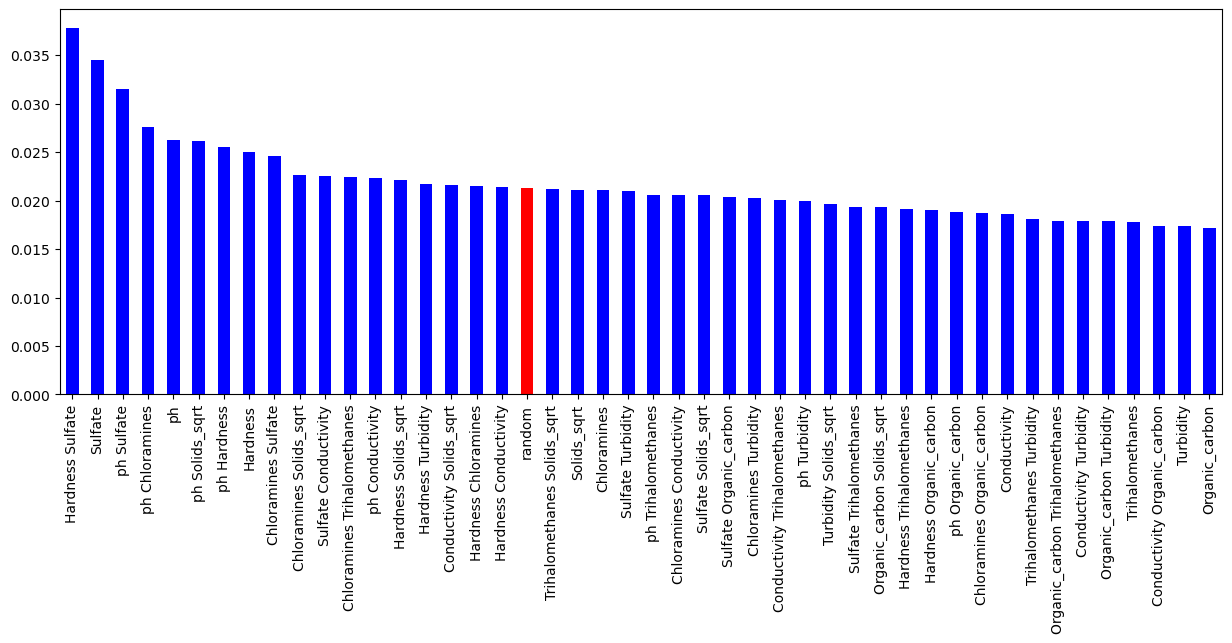

In [68]:
feat_imp = pd.Series(rfc.feature_importances_, index=train_df.drop('not_potible', axis=1).columns).sort_values(ascending=False)
colors = ['blue' if c != 'random' else 'red' for c in feat_imp.index]
feat_imp.plot(kind='bar', color=colors, figsize=(15, 5));

More than half of the features are less important than random noise, but some of the more important features are interactions between orginal features. A few of the orginal features are among some of the least important, like 'Organic_carbon', 'Turbidity', 'Trihalomethanes', and 'Conductivity'. I also don't see 'Turbidity' or 'Organic_carbon' among the important interactions. The most important feature found is an interaction feature.

In [69]:
drop_features = feat_imp[feat_imp <= feat_imp['random']].index
drop_features

Index(['random', 'Trihalomethanes Solids_sqrt', 'Solids_sqrt', 'Chloramines',
       'Sulfate Turbidity', 'ph Trihalomethanes', 'Chloramines Conductivity',
       'Sulfate Solids_sqrt', 'Sulfate Organic_carbon',
       'Chloramines Turbidity', 'Conductivity Trihalomethanes', 'ph Turbidity',
       'Turbidity Solids_sqrt', 'Sulfate Trihalomethanes',
       'Organic_carbon Solids_sqrt', 'Hardness Trihalomethanes',
       'Hardness Organic_carbon', 'ph Organic_carbon',
       'Chloramines Organic_carbon', 'Conductivity',
       'Trihalomethanes Turbidity', 'Organic_carbon Trihalomethanes',
       'Conductivity Turbidity', 'Organic_carbon Turbidity', 'Trihalomethanes',
       'Conductivity Organic_carbon', 'Turbidity', 'Organic_carbon'],
      dtype='object')

In [70]:
print(f'Cross val score with all features: {cross_val_score(rfc, train_df.drop("not_potible", axis=1), train_df.not_potible, cv=5).mean()}')
print(f'Cross val score without drop features: {cross_val_score(rfc, train_df.drop(["not_potible"] + list(drop_features), axis=1), train_df.not_potible, cv=5).mean()}')

Cross val score with all features: 0.666030534351145
Cross val score without drop features: 0.6717557251908397


That's good to see. That after dropping the features less important than random noise, the model performed better.

# Sequential Feature Selection

The next feature selection method I will use is sequential feature selection. First, I want to see which model I should use in the selection so I'll test a few to see which one performs the best.

In [71]:
models = [
    ('Logistic Regression', LogisticRegression(random_state=8675309)),
    ('Random Forest', RandomForestClassifier(random_state=8675309)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=8675309)),
    ('SVM', SVC(random_state=8675309)),
    ('KNN', KNeighborsClassifier()),
    ('Neural Network', MLPClassifier(max_iter=1000, random_state=8675309))
]

for name, model in models:
    pipe = make_pipeline(StandardScaler(), model)
    print(f'{name}: {cross_val_score(pipe, train_df.drop("not_potible", axis=1), train_df.not_potible).mean()}')

Logistic Regression: 0.6538167938931297
Random Forest: 0.668702290076336
Gradient Boosting: 0.663740458015267
SVM: 0.6572519083969466
KNN: 0.6164122137404581
Neural Network: 0.6324427480916031


Looks like the best model is the random forest model. I'll use that for the feature selection.

In [72]:
sfs = SequentialFeatureSelector(RandomForestClassifier(n_estimators=50, random_state=8675309), tol=0.0001, n_jobs=-1)
sfs.fit(train_df.drop('not_potible', axis=1), train_df.not_potible)
sfs.get_feature_names_out()

array(['ph', 'Chloramines', 'Sulfate', 'Solids_sqrt', 'ph Chloramines',
       'Hardness Sulfate', 'Turbidity Solids_sqrt'], dtype=object)

In [73]:
feat_imp[feat_imp > feat_imp['random']].index

Index(['Hardness Sulfate', 'Sulfate', 'ph Sulfate', 'ph Chloramines', 'ph',
       'ph Solids_sqrt', 'ph Hardness', 'Hardness', 'Chloramines Sulfate',
       'Chloramines Solids_sqrt', 'Sulfate Conductivity',
       'Chloramines Trihalomethanes', 'ph Conductivity',
       'Hardness Solids_sqrt', 'Hardness Turbidity',
       'Conductivity Solids_sqrt', 'Hardness Chloramines',
       'Hardness Conductivity'],
      dtype='object')

Some of my engineered interactions are among those chosen by the feature selection. They also differ from those found by the random forest feature importance. The feature selector isn't considering all the features at once, so it makes sense that some of the features found by the random forest feature importance aren't found by the feature selector.

In [74]:
sfs_df = pd.DataFrame(sfs.transform(train_df.drop('not_potible', axis=1)), columns=sfs.get_feature_names_out())
sfs_df['not_potible'] = train_df.not_potible
sfs_df

,ph,Chloramines,Sulfate,Solids_sqrt,ph Chloramines,Hardness Sulfate,Turbidity Solids_sqrt,not_potible
0,8.846282,6.057868,317.150545,133.172631,53.589605,59755.920045,389.534947,1.0
1,5.166226,8.637098,334.494997,109.818075,44.621199,45395.040580,506.076763,1.0
2,8.195765,6.295405,327.193898,101.929105,51.595662,70188.853114,328.080152,0.0
3,6.809645,8.681983,334.494997,187.085929,59.121221,60115.280499,595.644849,0.0
4,7.065416,10.088771,312.954695,144.168540,71.281368,59148.777172,742.402015,0.0
...,...,...,...,...,...,...,...,...
2615,7.965337,7.106043,352.316182,158.979905,56.602033,53390.659717,539.098015,1.0
2616,7.482791,8.171865,369.190878,140.076140,61.148364,68703.997690,573.576256,1.0
2617,7.025504,7.276065,304.732203,147.934237,51.118026,62592.155832,435.156713,1.0
2618,7.117579,6.387037,335.348881,177.563928,45.460240,62441.854412,769.455836,1.0


In [75]:
cross_val_score(RandomForestClassifier(), sfs_df.drop('not_potible', axis=1), sfs_df.not_potible).mean()

np.float64(0.6687022900763359)

This is almost the exact same as the random forest with all features. 

# Data transformation and loading

I'll keep all the features found by both methods.

In [76]:
keep_features = list(sfs.get_feature_names_out()) + list(feat_imp[feat_imp > feat_imp['random']].index)
keep_features = list(set(keep_features))
keep_features

['ph',
 'ph Sulfate',
 'ph Chloramines',
 'ph Hardness',
 'Chloramines Trihalomethanes',
 'Hardness Sulfate',
 'Chloramines',
 'Chloramines Solids_sqrt',
 'Hardness Solids_sqrt',
 'Turbidity Solids_sqrt',
 'Conductivity Solids_sqrt',
 'Sulfate Conductivity',
 'Sulfate',
 'Hardness Turbidity',
 'Hardness',
 'Hardness Conductivity',
 'Chloramines Sulfate',
 'Solids_sqrt',
 'ph Conductivity',
 'Hardness Chloramines',
 'ph Solids_sqrt']

In [77]:
new_df = train_df[keep_features].copy()
new_df['not_potible'] = train_df.not_potible
print(f'Original shape: {train_df.shape}')
print(f'New shape: {new_df.shape}')

Original shape: (2620, 47)
New shape: (2620, 22)


In [79]:
cross_val_score(RandomForestClassifier(), new_df.drop('not_potible', axis=1), new_df.not_potible).mean()

np.float64(0.6706106870229008)

Slightly worse than the random forest with only features selected by feature importance, but who knows how it'll do when I start tuning hyperparameters. There's a chance a few extra features could help.

In [78]:
new_df.to_sql('feat_reduced_train_set', db_con, if_exists='replace', index=False, schema='cleaned', method='multi', chunksize=10)

2620

# Summary

In week 3 I created all the interactions between the metrics in the dataset. This was due to the low number of starting features in the dataset and my lack of domain knowledge. I used random forest feature importance to select the most important features from all the orginals plus the interactions. Additionally, I used forward sequential feature selection to find a few more features that could be useful to the model. I will keep all the features found by both methods for the final model and tune hyperparameters to see if I can improve the model's performance. 

I tried models with 46, 7, and 18 predictive features. In the end I have 22. The model that had the best cross validated accuracy had 18 features. This seems like a good sign that I ended with an appropriate number of features. I have close to the best scoring number, but a few more to have a little extra flexibility in my model tuning. 